## Let's start with the imports

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import json
import pickle
import urllib

from sklearn.preprocessing import MultiLabelBinarizer

print(tf.__version__)

# Download the data from GCS
!wget 'https://storage.googleapis.com/movies_data/movies_metadata.csv'

top_genres = ['Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction']

data = pd.read_csv('movies_metadata.csv')


W0405 04:51:42.568092 140426093991808 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
--2019-04-05 04:51:43--  https://storage.googleapis.com/movies_data/movies_metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34445126 (33M) [application/octet-stream]
Saving to: ‘movies_metadata.csv.5’

movies_metadata.csv 100%[===================>]  32.85M  92.9MB/s    in 0.4s    

2019-04-05 04:51:44 (92.9 MB/s) - ‘movies_metadata.csv.5’ saved [34445126/34445126]



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print('Total number of movies: ',len(data))
print('total number of NaN in the column genres : ',data['genres'].isnull().sum())
print('total number of NaN in the column overview : ',data['overview'].isnull().sum())

# Remove the missing values
missing_idx = data[data['overview'].isnull()==True].index
dat = data.drop(missing_idx)
dat = dat.reset_index(drop=True)

dat = dat[:2500] # subset like this for example
dat.head(3)

Total number of movies:  45466
total number of NaN in the column genres :  0
total number of NaN in the column overview :  954


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


A sample of 2500 movies is selected from the original dataset. It seems that each movie could have more than one genres. We would want to check out the genres we have and reorganize them to be the target variable we could use for the prediction.

In [0]:
genres = dat['genres']
movies_genres = []

for i in range(len(dat['genres'])):
    a = genres[i].split("'name': ")
    a_genres = []
    if len(a) > 2:
        for j in range(len(a)-1):
            a_genres.append(a[j+1].split('},')[0].split("'")[1])
    elif len(a) == 2:
        a_genres.append(a[1].split('},')[0].split("'")[1])
    elif len(a) == 1:
        a_genres.append('')
    movies_genres.append(a_genres)

In [0]:
# Build a new dataframe used for the model
new_dat_dict = {'genres':movies_genres,'summary':dat['overview'].values}
new_dat = pd.DataFrame(new_dat_dict)
new_dat.head(2)

,genres,summary
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...


In [0]:
# The index of the movie with empty genre
empty_idx = [i for i,gen in enumerate(movies_genres) if gen[0]=='']
modified_genres = []
print('Number of Empty genre index: ',len(empty_idx))
new_dat = new_dat.drop(empty_idx)
new_dat = new_dat.reset_index(drop=True)

Number of Empty genre index:  62


In [0]:
movies_genres = list(new_dat['genres'].values)
# Flatten all the genres and find out the unique genres of the movies we choose
def flatten(list):
    for i in list:
        for j in i:
            yield j
all_genres = list(flatten(movies_genres))

# The unique genres of our selected sample
print(set(all_genres))

{'Comedy', 'Music', 'Animation', 'Romance', 'Adventure', 'Crime', 'Thriller', 'Western', 'Foreign', 'History', 'War', 'Family', 'Drama', 'Horror', 'Science Fiction', 'TV Movie', 'Fantasy', 'Documentary', 'Mystery', 'Action'}


Now, how to select the genres we want to use for the prediction task? There are two ways. The first one is to check the correlation of the occurency among the genres assigned for these movies. And then, we could combine the genres with high occurence correlations into a new genre. However, here to save the time, I would just use the Top genres provided here for the prediction task.

We could take a look at a heat map for the occurence of each genres (Some genres would appear together for one movie).

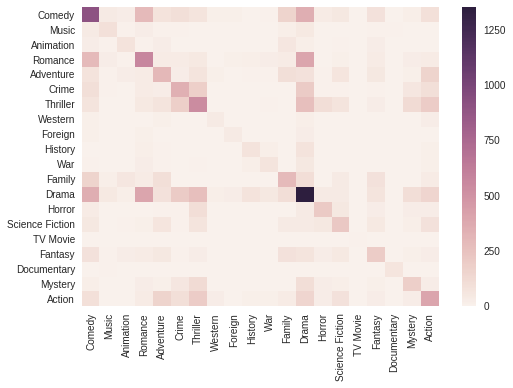

In [0]:
import seaborn as sns

# Transfer the genres to the ids
all_genres_list = list(set(all_genres))
id_set = [i for i,t in enumerate(all_genres_list)]
heat_matrix = np.zeros((len(id_set), len(id_set)))

# Add up the heat map matrix
for a1 in movies_genres:
    id = []
    for a2 in a1:
        id.append(all_genres_list.index(a2))
    for i in id:
        for j in id:
            heat_matrix[i,j] = heat_matrix[i,j]+1

# Heat map
sns.heatmap(heat_matrix, xticklabels=all_genres_list, yticklabels=all_genres_list)

Let's modify the dataset again to keep the movies we want for the training based on the top genres we set.

In [0]:
# Select the movies with only one genre matching the Top genres we set
new_genres = []

for gens in movies_genres:
    new_gen = [a for a in gens if a in top_genres]
    new_genres.append(new_gen)
    
one_idx = [i for i,t in enumerate(new_genres) if len(t)==1 and t is not '']
one_genre = [t[0] for i,t in enumerate(new_genres) if len(t)==1 and t is not '']

939 movies are selected here for the model building to do the prediction. The target would only have one genre. Limited to the time here, I would only deal with such a simple target response variable.

In [0]:
# Add the Target Genre into the dataframe
select_movies = new_dat.iloc[one_idx,:]
select_movies['Target Genre'] = one_genre
select_movies.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,genres,summary,Target Genre
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",Comedy
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,Adventure


Now it is the time to modify the predict variable, whcih is the summary of the movie. The summary of the movie contains short sentences. We need to transfer these sentences into numerical vectors of wrods.

To make the texts usable and meaningful, we need to do three steps. The first step is to transfer all the texts into a frequency matrix. Here I just use the naive way, which is the bag of words tech that count the appearing fequency for each word in all the summary sentences. Use the package 'CountVectorizer', we could easily do that. 

However, not every word is meaningful. So the second step is that we would want get rid of the words that appear too often in all the sentences and the words that appear too seldom (Too unique for each movie, might not be general when we try to train a prediction model). 

The third step is to give a weight indicating the importance of the word. For the meaningful words, the word appears too often would still be less important, such as 'about', 'for'. They would have a smaller weight. But in the low-frequent words, the word appears more times would be relatively important (indicate some features). We would simply apply 'TfidfTransformer' package to help us assign all the weightage.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

summaries = list(select_movies['summary'].values) # All summary contents
vectorize=CountVectorizer(max_df=0.95, min_df=0.005) # Remove words too frequent or too seldom
c=vectorize.fit_transform(summaries) # Modified words sparse matrix
feature_name = vectorize.get_feature_names() # The words left text
c_matrix = c.toarray() # The frequency matrix

Before we assign the weight for the words, we would want to do a word stemming. Because it is very common that different variations of the same word get counted as seperate words. We would want to combine them so that we could condense the information to extract features.

In [0]:
feature_name
c_matrix.sum(axis=1)